In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from utils import *

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


## TRAINING ON MNIST DATASET

x_train shape (60000, 28, 28, 1)
y_train shape (60000,)
x_test shape (10000, 28, 28, 1)
y_test shape (10000,)


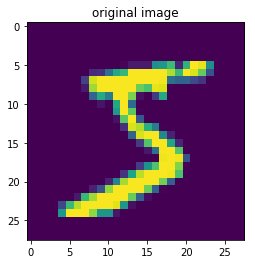

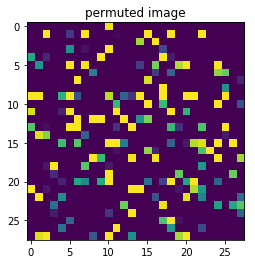

In [2]:
SECRET_SEED = 87
(x_train, y_train, x_test, y_test) = get_dataset('mnist')
plt.figure()
plt.imshow(x_train[0,:,:,0])
plt.title('original image')

x_train_shuffle = permute_pixels(x_train, SECRET_SEED)
x_test_shuffle = permute_pixels(x_test, SECRET_SEED)
plt.figure()
plt.imshow(x_train_shuffle[0,:,:,0])
plt.title('permuted image')
plt.show()

In [3]:
model = get_ppd_model('mnist')
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train_shuffle, y_train, epochs=5, verbose=1, batch_size=128, validation_data=(x_test_shuffle, y_test))
model.save('models/mnist_trained_keras_model.hdf5')
print(model.evaluate(x_test_shuffle, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 20s 337us/step - loss: 0.2966 - acc: 0.9093 - val_loss: 0.1622 - val_acc: 0.9506
Epoch 2/5
60000/60000 [==============================] - 17s 276us/step - loss: 0.0928 - acc: 0.9710 - val_loss: 0.1652 - val_acc: 0.9511
Epoch 3/5
60000/60000 [==============================] - 16s 272us/step - loss: 0.0446 - acc: 0.9855 - val_loss: 0.1631 - val_acc: 0.9542
Epoch 4/5
60000/60000 [==============================] - 18s 294us/step - loss: 0.0282 - acc: 0.9909 - val_loss: 0.1801 - val_acc: 0.9551
Epoch 5/5
10000/10000 [==============================] - 2s 193us/step
[0.19576399628734797, 0.9526]


## TRAINING ON CIFAR10 DATASET

x_train shape (50000, 32, 32, 3)
y_train shape (50000, 1)
x_test shape (10000, 32, 32, 3)
y_test shape (10000, 1)


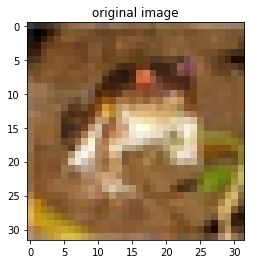

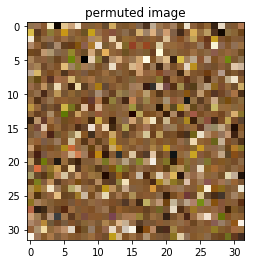

In [4]:
SECRET_SEED = 87
(x_train, y_train, x_test, y_test) = get_dataset('cifar10')
plt.figure()
plt.imshow(x_train[0])
plt.title('original image')

x_train_shuffle = permute_pixels(x_train, SECRET_SEED)
x_test_shuffle = permute_pixels(x_test, SECRET_SEED)
plt.figure()
plt.imshow(x_train_shuffle[0])
plt.title('permuted image')
plt.show()

In [5]:
model = get_ppd_model('cifar10')
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train_shuffle, y_train, epochs=5, verbose=1, batch_size=128, validation_data=(x_test_shuffle, y_test))
model.save('models/cifar10_trained_keras_model.hdf5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 41s 824us/step - loss: 1.7567 - acc: 0.4016 - val_loss: 1.5952 - val_acc: 0.4422
Epoch 2/5
50000/50000 [==============================] - 42s 843us/step - loss: 1.2804 - acc: 0.5526 - val_loss: 1.6049 - val_acc: 0.4545
Epoch 3/5
50000/50000 [==============================] - 50s 999us/step - loss: 0.9430 - acc: 0.6715 - val_loss: 1.7288 - val_acc: 0.4560
Epoch 4/5
50000/50000 [==============================] - 42s 832us/step - loss: 0.6273 - acc: 0.7807 - val_loss: 2.0095 - val_acc: 0.4402
Epoch 5/5
50000/50000 [==============================] - 41s 823us/step - loss: 0.3916 - acc: 0.8661 - val_loss: 2.3237 - val_acc: 0.4331


## Train and Save 10 PPD Models

In [6]:
for dataset in ['mnist','cifar10']:
    (x_train, y_train, x_test, y_test) = get_dataset(dataset)

    for SECRET_SEED in range(10):
        x_train_shuffle = permute_pixels(x_train, SECRET_SEED)
        x_test_shuffle = permute_pixels(x_test, SECRET_SEED)
        model = get_ppd_model(dataset)
        model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        model.fit(x_train_shuffle, y_train, epochs=5, verbose=2, batch_size=128, validation_data=(x_test_shuffle, y_test))
        model.save('models/'+dataset+'_trained_keras_model_'+str(SECRET_SEED)+'.hdf5')

x_train shape (60000, 28, 28, 1)
y_train shape (60000,)
x_test shape (10000, 28, 28, 1)
y_test shape (10000,)
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 18s - loss: 0.2971 - acc: 0.9095 - val_loss: 0.1596 - val_acc: 0.9483
Epoch 2/5
 - 18s - loss: 0.0916 - acc: 0.9707 - val_loss: 0.1427 - val_acc: 0.9550
Epoch 3/5
 - 17s - loss: 0.0414 - acc: 0.9866 - val_loss: 0.1512 - val_acc: 0.9584
Epoch 4/5
 - 16s - loss: 0.0332 - acc: 0.9888 - val_loss: 0.1595 - val_acc: 0.9580
Epoch 5/5
 - 18s - loss: 0.0314 - acc: 0.9891 - val_loss: 0.2043 - val_acc: 0.9518
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 16s - loss: 0.3007 - acc: 0.9098 - val_loss: 0.1765 - val_acc: 0.9460
Epoch 2/5
 - 18s - loss: 0.0923 - acc: 0.9709 - val_loss: 0.1514 - val_acc: 0.9542
Epoch 3/5
 - 18s - loss: 0.0478 - acc: 0.9843 - val_loss: 0.1918 - val_acc: 0.9455
Epoch 4/5
 - 17s - loss: 0.0346 - acc: 0.9881 - val_loss: 0.1856 - val_acc: 0.9547
Epoch 5/5
 - 17s - loss: 0.0241 - acc: 0.99

Epoch 2/5
 - 39s - loss: 1.2769 - acc: 0.5553 - val_loss: 1.5705 - val_acc: 0.4606
Epoch 3/5
 - 42s - loss: 0.9454 - acc: 0.6678 - val_loss: 1.7328 - val_acc: 0.4605
Epoch 4/5
 - 48s - loss: 0.6226 - acc: 0.7812 - val_loss: 1.9827 - val_acc: 0.4478
Epoch 5/5
 - 42s - loss: 0.3872 - acc: 0.8650 - val_loss: 2.3966 - val_acc: 0.4438
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
 - 39s - loss: 1.7495 - acc: 0.4064 - val_loss: 1.5621 - val_acc: 0.4476
Epoch 2/5
 - 38s - loss: 1.2586 - acc: 0.5618 - val_loss: 1.5898 - val_acc: 0.4593
Epoch 3/5
 - 37s - loss: 0.9151 - acc: 0.6828 - val_loss: 1.7577 - val_acc: 0.4524
Epoch 4/5
 - 38s - loss: 0.5920 - acc: 0.7963 - val_loss: 2.0451 - val_acc: 0.4527
Epoch 5/5
 - 37s - loss: 0.3557 - acc: 0.8785 - val_loss: 2.3790 - val_acc: 0.4500
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
 - 39s - loss: 1.7607 - acc: 0.4000 - val_loss: 1.6059 - val_acc: 0.4397
Epoch 2/5
 - 38s - loss: 1.2765 - acc: 0.5537 - val_loss: 1.6014 - val